#### SCS Implementation

The following outlines the symbol clock synchronizer (SCS) subsystem used in communications systems with non-coherent transmitter and receiver architectures. This highlights the various submodules needed to correct clock offsets and explains their internal functionalities. While a phase-locked loop (PLL) can synchronize to track the wavefrom envelope, the analog-to-digital converter produces a sampled version of the received signal that is not coherent with the ideal symbol times. The SCS addresses the small clock offsets needed to be made in order to sample at the optimal rate allowing for synchronization to be reintroduced between the transmitter and receiver. Figure 1 below displays the different SCS submodules and their placement within the subsystem.

<div style="text-align: center;">
    <img src="./images/SCS/scs_diagram.png" alt="" width="1000" />
    <p style="text-align: center;">Figure 1: SCS Subsystem Architecture</p>
</div>

#### System Configuration

Before describing the SCS further, the developed signal processing library, along with two additional libraries for plotting and linear algebra, must be imported. These libraries will be useful for the later visualization of the system's internal variables.

In [1]:
from helper_functions import sp_library as sp
import numpy as np 
import matplotlib.pyplot as plt

#### Downsampling
The SCS subsystem expects 2 samples per symbol as input and produces one sample per symbol as output. Therefore the incoming receive signal samples must be downsampled by a factor of $\frac{N}{2}$ to acheive the 2 samples per symbol input. This process is represented mathmatically below

$$
x\left(nT_s\right)\:\rightarrow \:\:\:x_{downsampled}\left(nT_s\cdot \:\:\frac{N}{2}\right)\:\rightarrow \:x\left(nT_N\right)
$$

where:
- $T_s$ is the sample duration corresponding to N samples per symbol,
- $N/2$ is the downsampling rate required to obtain a resulting 2 samples per symbol,
- $T_N$ is the sample duration corresponding to 2 samples per symbol.
 
The following excerpt shows a test cases of the downsampling module later used in the full SCS subsystem as well as plots its input and output.

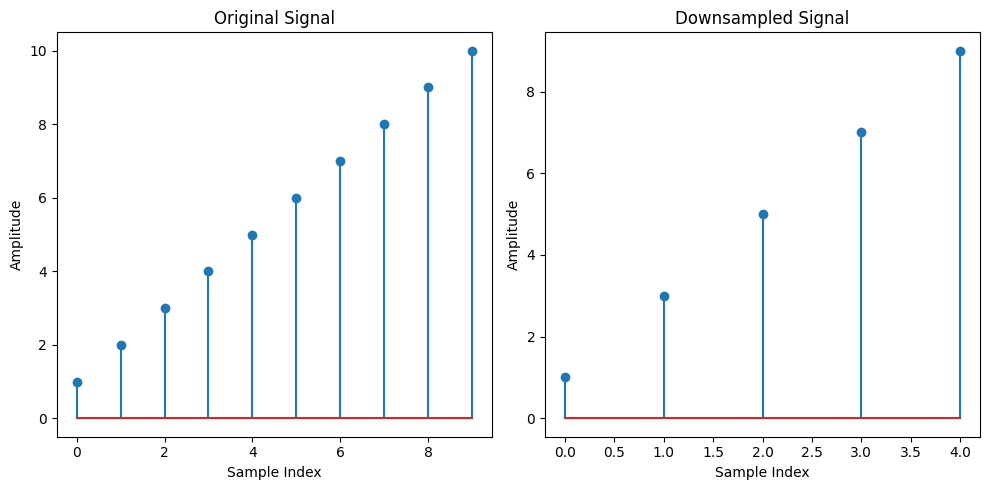

In [2]:
# test input samples
signal = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
downsample_factor = 2

# downsampling
downsampled_signal = sp.downsample(signal, downsample_factor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.stem(signal)
plt.title("Original Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.subplot(1, 2, 2)
plt.stem(downsampled_signal)
plt.title("Downsampled Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

#### Interpolator
The interpolator module takes in the receive signal represented by 2 samples per symbol aswell as a calculated timing adjustment and produces a offset sample corresponding to the optimal sample time. This new sample is produced via approximating a parabolic interpolation of the current input sample, as well as the previous and next interpolation outputs in which the corresponding optimal sample is returned. This process is demonstrated below in figure as well as the subsequent equations.

<div style="text-align: center;">
    <img src="./images/SCS/scs_interpolation_example.png" alt="" width="500" />
    <p style="text-align: center;">Figure 2: Optimal Sample Selection via Parabolic Interpolation</p>
</div>

The internal architecture of the module follows a farrow filter structure seen below.

<div style="text-align: center;">
    <img src="./images/SCS/scs_farrow_interpolator.png" alt="" width="600" />
    <p style="text-align: center;">Figure 3: Farrow Interpolation Structure Block Diagram</p>
</div>

INTERPOLATION EQUATION

In [3]:
# INTERPOLATION CODE HERE

#### Early-Late Timing Error Detector

The early-late timing error detector (ELTED) module relies on three samples as input to calculate a proportionate timing adjustment, this includes the previous, current, and next sample which are stored in a shifting register. The late sample value is subtracted from the early sample to approximate a derivative of the current sample where approximation is then multiplied by the sign of the current sample to account for ambiguities between positive and negative constellation points. The result of this calculation is a proportional timing adjustment, which tells the system how to shift its sampling clock to better align with the peak of the pulse. This correction is crucial for maintaining accurate symbol detection, particularly in environments where timing drifts due to channel conditions or other factors. This process is shown below in Figure 4 as well as the subsequent equation.

<div style="text-align: center;">
    <img src="./images/SCS/scs_ted_example.png" alt="" width="500" />
    <p style="text-align: center;">Figure 4: Example ELTED Data Points</p>
</div>

$$
e\left(kT_s\right)=sgn\left\{x\left(kTs\right)\right\}\cdot \:\left[x\left(\left(k+\frac{1}{2}\right)T_s\right)-x\left(k\left(-\frac{1}{2}\right)T_s\right)\right]
$$

where:
- $x(kT_s)$ represents the current sample,
- $x\left(\left(k+\frac{1}{2}\right)T_s\right)$ represents the next sample,
- $x\left(k\left(-\frac{1}{2}\right)T_s\right)$ represents the previous sample.

This calculation can be made for the real or imaginary channels in a quadrature system as it is assumed that the same ADC was used for discretization and therefore the two channels are synchronized. The following excerpt shows the timing error detector implementation used later in the SCS subsystem.

In [4]:
def early_late_ted(early_sample, current_sample, late_sample):
        e_nT = (late_sample - early_sample) * (-1 if current_sample < 0 else 1)
        return e_nT

# test sample inputs
early_sample = 1.0
current_sample = -0.5
late_sample = 2.0

ted_output = early_late_ted(early_sample, current_sample, late_sample)
print(f"\nCalculated Clock Offset: {ted_output}\n")


Calculated Clock Offset: -1.0



#### Loop Filter

The loop filter module provides stability for the overall PLL system by shaping the transient response. During instantiation of a PLL system, a loop bandwidth and damping factor are defined as parameters shaping this transient response. The loop bandwidth specifies the speed at which the PLL will converge towards matching the input reference signal, setting a wider loop bandwidth allows the PLL to respond more rapidly respond to input frequency changes but introduces more internal noise. The damping factor specifies how the oscillations decay in the transient response when a input frequency change is introduced. Together these parameters categorize the loop filter coefficients $K_1$ and $K_2$ seen in figure 2.

<div style="text-align: center;">
    <img src="./images/PLL/pll_loop_filter_diagram.png" alt="" width="500" />
    <p style="text-align: center;">Figure 5: Loop Filter Internal Architecture</p>
</div>

The derivations of $K_1$ and $K_2$ are shown below
$$
K_1 = \frac{4 \xi \left( \frac{B_n T_s}{\zeta + \frac{1}{4 \zeta}} \right)}{1 + 2 \zeta \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right) + \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2} \quad \quad \quad K_2 = \frac{4 \left( \frac{B_n T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2}{1 + 2 \zeta \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right) + \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2}
$$

where:
- $B_n$ represents the loop bandwidth (usually normalized for the sample rate $f_s$),
- $\zeta$ represents the damping factor,
- $T_s$ is the sampling period of the system.

The following excerpt shows the loop filter coeffiencient calculations later used in the full SCS subsystem. 

In [5]:
def compute_loop_constants(fs, lb, df):
    denominator = 1 + ((2 * df) * ((lb * (1 / fs)) / (df + (1 / (4 * df))))) + ((lb * (1 / fs)) / (df + (1 / (4 * df)))) ** 2
    K1 = ((4 * df) * ((lb * (1 / fs)) / (df + (1 / (4 * df))))) / denominator
    K2 = (((lb * (1 / fs)) / (df + (1 / (4 * df)))) ** 2) / denominator
    return K1, K2

sample_rate = 8
loop_bandwidth = 0.02 * sample_rate
damping_factor = 1 / np.sqrt(2)
k1, k2 = compute_loop_constants(sample_rate, loop_bandwidth, damping_factor)

print("\nLoop Filter Configuration Parameters")
print(f"Sample Rate: {sample_rate}")
print(f"Loop Bandwidth: {loop_bandwidth}")
print(f"Damping Factor: {np.round(damping_factor, 5)}")
print(f"Loop Filter Coefficient K1: {np.round(k1, 5)}")
print(f"Loop Filter Coefficient K2: {np.round(k2, 5)}\n")


Loop Filter Configuration Parameters
Sample Rate: 8
Loop Bandwidth: 0.16
Damping Factor: 0.70711
Loop Filter Coefficient K1: 0.05193
Loop Filter Coefficient K2: 0.00035



#### Mod-1 Decrementing Counter
The mod-1 decrementing counter is used specifically because of the 2 samples per symbol input rate. This module tracks when to perform a new timing offset calculation as well as when to select a sample at the sub system output. Given a initial value, the decrementor decreases by $\frac{1}{2}$ each input sample adjusted by the loop filter output. As soon as the value of the decrementor becomes negative a strobe occurs indicating to the system that the current sample corresponds to a pulse peak and should be adjusted and output. The internal functionality of the module is shown below in Figure 6. 

<div style="text-align: center;">
    <img src="./images/SCS/scs_mod_counter.png" alt="" width="700" />
    <p style="text-align: center;">Figure 6: Mod-1 Decrementing Counter Internal Architecture</p>
</div>

where:
- $m(k)$ is the current counter value,
- $m(k-1)$ is the previous counter value,
- $v(k)$ is the loop filter output.

The following excerpt shows the decrementing mod-1 counter implementation used later in the full SCS subsystem.

In [6]:
def update_counter(counter, loop_filter_output):
    # update the decrementing counter
    counter -= (0.5 + loop_filter_output)
    
    # check if the counter is negative
    if counter < 0:
        print("Strobe activated.")
        counter = counter + 1  # mod 1
    
    return counter

# test inputs
loop_filter_outputs = [0.01, 0.02, 0.03, 0.02, 0.01]
current_value = 1.0

print("Starting Mod-1 Decrementing Counter Simulation:")
for output in loop_filter_outputs:
    current_value = update_counter(current_value, output)
    print(f"Current Counter Value: {current_value:.2f}")


Starting Mod-1 Decrementing Counter Simulation:
Current Counter Value: 0.49
Strobe activated.
Current Counter Value: 0.97
Current Counter Value: 0.44
Strobe activated.
Current Counter Value: 0.92
Current Counter Value: 0.41


#### Clock Offset Calculation
Using the current mod-1 decrementing counter value and loop filter output the timing offset is produced. When the decrementing counter strobe is activated, the previous counter value is divided by the adjusted loop filter output and fed into the interpolator for sampling adjustment. This calculation of the timing offset is mathmatically represented below

$$
\mu \left(k\right)=\frac{m\left(k-1\right)}{w\left(k\right)}
$$

where:
- $\mu(k)$ is the produced clock offset,
- $m(k-1)$ is the previous decrementing counter output,
- $w(k)$ is the adjusted loop filter output.

The following excerpt shows the decrementing mod-1 counter implementation used later in the full SCS subsystem.

In [7]:
def compute_mu(counter_prev, lf_adjusted_output):
    if lf_adjusted_output < 1:
        lf_adjusted_output = 1
    return counter_prev / lf_adjusted_output

# test case 1
counter_prev_1 = 1.0
lf_adjusted_output_1 = 0.5
expected_output_1 = 2.0
mu = compute_mu(counter_prev_1, lf_adjusted_output_1)
print(f"Computed Timing Offset: {mu} symbols")

# test case 2
counter_prev_2 = 2.0
lf_adjusted_output_2 = 0.0
mu = compute_mu(counter_prev_2, lf_adjusted_output_2)
print(f"Computed Timing Offset: {mu} symbols")

Computed Timing Offset: 1.0 symbols
Computed Timing Offset: 2.0 symbols


#### Sample Selection

In the complete SCS subsystem diagram, input data is received at a rate of 2 samples per symbol, while the desired output is 1 sample per symbol. After the timing offset adjustment is applied, the final downsampling is handled by the select sample module. This module permits a sample to pass only when a strobe is activated. The process ensures that all components of the system are synchronized via the mod-1 decrementing counter. This output is then streamed to the subsequent stages of the receiver architecture.

&nbsp;
### QPSK Integration

The PLL described above serves as the foundation for symbol timing synchronization in a quadrature communication receiver. Figure 7 below demonstrates its integration into a QPSK system.

<div style="text-align: center;">
    <img src="./images/SCS/scs_full_system_diagram.png" alt="" width="1500" />
    <p style="text-align: center;">Figure 7: QPSK Receiver SCS Placement</p>
</div>

&nbsp;
### Transmitter

The QPSK tranmitter can be simulated similarly to as done in the *QPSK.ipynb* notebook example. This process is summarized below.

#### Bit to Symbol Mapping

In [8]:
qpsk_constellation = [[complex( np.sqrt(1) +  np.sqrt(1)*1j), 3], 
                    [complex( np.sqrt(1) + -np.sqrt(1)*1j), 2], 
                    [complex(-np.sqrt(1) + -np.sqrt(1)*1j), 0], 
                    [complex(-np.sqrt(1) +  np.sqrt(1)*1j), 1]]
fs = 8 # sample rate
fc = .25 * fs # carrier frequency
noise = 2*(10**-4) # system noise
input_message_ascii = "this is a qpsk transceiver test!"

# mapping the ascii characters to binary
input_message_bins = ''.join(sp.string_to_ascii_binary(input_message_ascii))

# grouping the binary into blocks of two bits
input_message_blocks = [input_message_bins[i:i+2] for i in range(0, len(input_message_bins), 2)]

# mapping each block to a symbol in the constellation
input_message_symbols = [int(bin2, 2) for bin2 in input_message_blocks]

bits_to_amplitude = {bit: amplitude for amplitude, bit in qpsk_constellation}

# inphase channel symbol mapping
xk = np.real([bits_to_amplitude[symbol] for symbol in input_message_symbols])

# quadrature channel symbol mapping
yk = np.imag([bits_to_amplitude[symbol] for symbol in input_message_symbols])

#### Adding Header

In [9]:
# adding header to each channel
header = [1,0] * 50
xk = np.concatenate([header, xk])
yk = np.concatenate([header, yk])

#### Upsampling

In [10]:
xk_upsampled = sp.upsample(xk, fs, interpolate_flag=False)
yk_upsampled = sp.upsample(yk, fs, interpolate_flag=False)

#### Introducing a Timing Offset

A timing offset is introduced to the upsampled symbols in the transmitter using two methods. The first method involves offsetting the signal's sample timings by interpolating and selecting an intermediate periodic sample to represent the entire signal. The second method creates an offset in the symbol spacing by removing a small segment of the input samples, which the SCS will later correct. Both methods can be adjusted in the following example.

In [11]:
timing_offset = 0.0
sample_shift = 1

xk_upsampled = sp.clock_offset(xk_upsampled, fs, timing_offset)[sample_shift:]
yk_upsampled = sp.clock_offset(yk_upsampled, fs, timing_offset)[sample_shift:]

#### Pulse Shaping

In [12]:
length = 64
alpha = 0.10
pulse_shape = sp.srrc(alpha, fs, length)

xk_pulse_shaped = np.real(sp.convolve(xk_upsampled, pulse_shape, mode="same")[1:])
yk_pulse_shaped = np.real(sp.convolve(yk_upsampled, pulse_shape, mode="same")[1:])

#### Digital Modulation

In [13]:
s_rf = (
    np.sqrt(2) * np.real(sp.modulate_by_exponential(xk_pulse_shaped, fc, fs, noise=noise)) +
    np.sqrt(2) * np.imag(sp.modulate_by_exponential(yk_pulse_shaped, fc, fs, noise=noise))
)

&nbsp;
### Receiver

dont know what to say here

#### Digital Demodulation

In [15]:
xr_nT = np.sqrt(2) * np.real(sp.modulate_by_exponential(s_rf, fc, fs))
yr_nT = np.sqrt(2) * np.imag(sp.modulate_by_exponential(s_rf, fc, fs))

#### Match Filtering

In [16]:
xr_nT_match_filtered = np.real(sp.convolve(xr_nT, pulse_shape, mode="same")[1:])
yr_nT_match_filtered = np.real(sp.convolve(yr_nT, pulse_shape, mode="same")[1:])

#### Down Sampling

The matched filtered signal represented by $N$ samples per symbol is now downsampled by a factor of $\frac{N}{2}$ producing a 2 samples per symbol representation.

In [17]:
xr_nT_downsampled = sp.downsample(xr_nT_match_filtered, int(fs/2))
yr_nT_downsampled = sp.downsample(yr_nT_match_filtered, int(fs/2))
r_nT = (xr_nT_downsampled + 1j* yr_nT_downsampled)

An excerpt from the downsampled signal as well as the complex constellations are plotted to illustrate the current state of the receive samples.

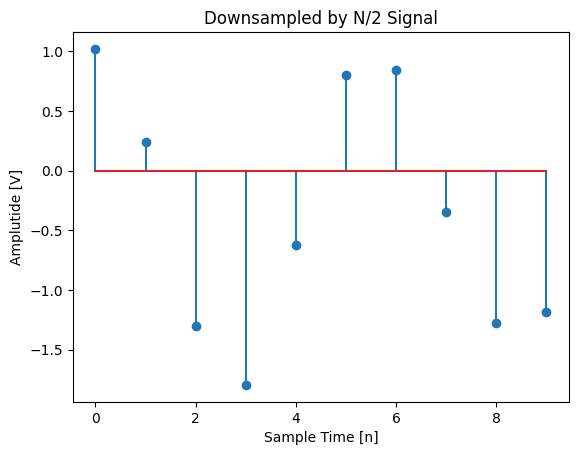

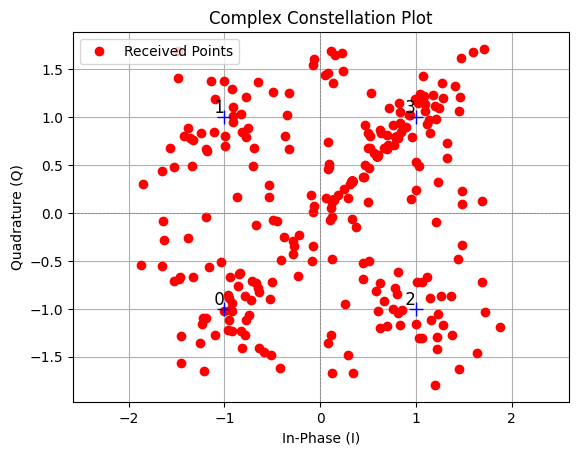

In [18]:
plt.figure()
plt.stem(yr_nT_downsampled[len(header)*2:(len(header)+5)*2])
plt.title("Downsampled by N/2 Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

# plot the downsampled constellation
sp.plot_complex_points(r_nT, constellation=qpsk_constellation)

&nbsp;
#### Symbol Clock Synchronization

A SCS object is first instantiated using the system samples per symbol, specified loop bandwidth, and damping factor.

In [19]:
loop_bandwidth = (fc/fs)*0.0006
damping_factor = 1/np.sqrt(2)

Before running the subsystem, the maximum system gain must be measured and normalized. This is performed by running the PLL in open loop mode by setting the *open_loop* flag to *True* and recording the maximum value.

In [20]:
scs = sp.SCS(samples_per_symbol=2, loop_bandwidth=loop_bandwidth, damping_factor=damping_factor, open_loop=True)

max_lf_output = 0
for i in range(len(r_nT)):
    lf_output = scs.insert_new_sample(r_nT[i])
    if lf_output > max_lf_output:
        max_lf_output = lf_output

print(f"\nSCS Measured System Gain: {1/max_lf_output}\n")


SCS Measured System Gain: 2144.2765327607663



The SCS module is then reinstantiated using this gain and run using the recieved input samples. The 1 sample per symbol constellation points are plotted to illustrate the subsystems performance.

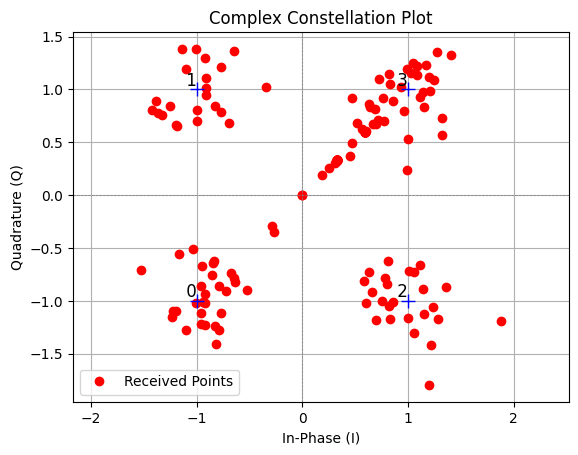

In [21]:
# running scs system
scs = sp.SCS(samples_per_symbol=2, loop_bandwidth=loop_bandwidth, damping_factor=damping_factor, gain=42)

corrected_constellations = []
for i in range(len(r_nT)):
    corrected_constellation = scs.insert_new_sample(r_nT[i])
    if corrected_constellation is not None:
        corrected_constellations.append(corrected_constellation)

sp.plot_complex_points(corrected_constellations, constellation=qpsk_constellation)

#### Symbol Decision
The 1 sample per symbol synchronized SCS output can now be mapped back from constelation points to symbols via the nearest neighobor algorithm, this process is discussed more thoroughly in the *QPSK.ipynb* notebook.

In [22]:
detected_symbols = sp.nearest_neighbor(corrected_constellations, qpsk_constellation)

# removing header and adjusting for symbol timing synchronization delay
detected_symbols = detected_symbols[len(header)+2:]

error_count = sp.error_count(input_message_symbols, detected_symbols)

print(f"Transmission Symbol Errors: {error_count}")
print(f"Bit Error Percentage: {round((error_count * 2) / len(detected_symbols), 2)} %")

Transmission Symbol Errors: 2
Bit Error Percentage: 0.04 %


Finally the estimated receive symbols are converted back to binar representation and the grouped into ascii characters.

In [23]:
# converting symbols to binary then binary to ascii
detected_bits = []
for symbol in detected_symbols:
    detected_bits += ([*bin(symbol)[2:].zfill(2)])

message = sp.bin_to_char(detected_bits)
print(message)

t(is is a qpsk transceiver test
